In [33]:
import sys,os
sys.path.append("../")

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.metrics import pairwise_distances  


%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import entropy
import itertools

import seaborn as sns

from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import pairwise_distances  
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

sns.set()
sns.set_style("darkgrid")

### Function to take weighted entropy

In [2]:
def weighted_entropy(dataframe, entropy_column, group_columns="cluster", ):
    group_size = dataframe.groupby(group_columns).size()
    group_entropy = dataframe.groupby(group_columns)[entropy_column].apply(lambda x: entropy(x.value_counts().values))
    weighted_entropy = (group_size * group_entropy).mean()
    return weighted_entropy

## reading the change object.

In [3]:
article_name = "John_Logie_Baird"
change_object_dir =  "../data/change objects/"
content_dir = "../data/content/"
filename =  f"{article_name}_change.h5"
change_object_file = os.path.join(change_object_dir, filename)
filename = article_name + ".h5"
filepath = os.path.join(content_dir, filename)
with pd.HDFStore(filepath, 'r') as store:
    token_string_df = store.get("all_tokens")

token_string_df = token_string_df.set_index("token_id")["str"]
token_string_df[-1] = "St@rt"
token_string_df[-2] = "$nd"


if os.path.exists(change_object_file):
    with pd.HDFStore(change_object_file, 'r') as store:
        change_object_dataframe = store.get("data")
else:
    print("file do not exist")
change_object_dataframe.shape


change_object_dataframe["ins_length"] = change_object_dataframe["ins_tokens"].str.len()
change_object_dataframe["del_length"] = change_object_dataframe["del_tokens"].str.len()

change_object_dataframe["del_string_tokens"] = change_object_dataframe["del_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))

change_object_dataframe["ins_string_tokens"] = change_object_dataframe["ins_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))
change_object_dataframe["edit_string_tokens"] = change_object_dataframe["ins_string_tokens"] + change_object_dataframe["del_string_tokens"]



change_object_dataframe["left_context"] = change_object_dataframe["left_token"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist())).str.join(" ")


change_object_dataframe["right_context"] = change_object_dataframe["right_token"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist())).str.join(" ")

change_object_dataframe["bykau_cluster"] = pd.Series(-99,index=change_object_dataframe.index)

# change_object_dataframe = change_object_dataframe[["left_context","del_string_tokens","ins_string_tokens", "right_context", 
#                                                    "ins_length", "del_length", "bykau_cluster" ]]
change_object_dataframe.head()

ins_start_pos  \
from revision id to revision id timestamp           timegap           editor                    
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           10.0   
                                                                             1           32.0   
                                                                             2           34.0   
                                                                             3           50.0   
                                                                             4           57.0   

                                                                                ins_end_pos  \
from revision id to revision id timestamp           timegap           editor                  
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0         30.0   
                                                                             1         32.0   
                                                                             2         34.0   
                                                                             3         55.0   
                                                                             4         73.0   

                                                                                left_neigh  \
from revision id to revision id timestamp           timegap           editor                 
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           9   
                                                                             1          10   
                                                                             2          11   
                                                                             3          26   
                                                                             4          32   

                                                                                right_neigh  \
from revision id to revision id timestamp           timegap           editor                  
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           10   
                                                                             1           11   
                                                                             2           12   
                                                                             3           32   
                                                                             4           36   

                                                                                del_start_pos  \
from revision id to revision id timestamp           timegap           editor                    
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           -1.0   
                                                                             1           -1.0   
                                                                             2           -1.0   
                                                                             3           27.0   
                                                                             4           33.0   

                                                                                del_end_pos  \
from revision id to revision id timestamp           timegap           editor                  
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0         -1.0   
                                                                             1         -1.0   
                                                                             2         -1.0   
                                                                             3         31.0   
                                                                             4         35.0   

                                                               

In [4]:
change_object_dataframe.shape

(4900, 20)

#### read annotations

In [5]:
file_name = article_name + "_FULL.csv"
annotation_dir = "../data/annotation/"
full_file_path = os.path.join(annotation_dir, file_name)
annotation_df = pd.read_csv(full_file_path)
annotation_df = annotation_df[["revid_ctxt", "token_id",
                               "rev_id", "nationality", "birth_place","Bulk" ]]
true_labels = np.zeros((annotation_df.shape[0]))
true_labels[(annotation_df["nationality"].str.strip() == "Y").values] = 1
annotation_df["nationality"] = true_labels

In [6]:
# file_name = article_name + "_FULL.csv"
# annotation_dir = "../data/annotation/"
# full_file_path = os.path.join(annotation_dir, file_name)
# annotation_df = pd.read_csv(full_file_path)

## Function for weighted entropy

In [7]:
def weighted_token_entropy(dataframe, group_by):
    cluster_sizes = dataframe.groupby(group_by).size()
    token_entropy_clusters = dataframe.groupby(group_by)["edit_string_tokens"].apply(
                    lambda token_tuples: entropy(pd.Series(
                    [token for token_tuple in token_tuples.tolist() for token in token_tuple]
                    ).value_counts().values))
    cluster_entropy = (cluster_sizes * token_entropy_clusters).sum()
    return cluster_entropy

### Clustering using jaccard

##### Defining jaccard similarity function.

In [8]:
def bykau_distances(dataframe, context = 8):
    left_neighbours = dataframe["left_context"].apply(lambda x: x.split(" ")[-context:])
    right_neighbours = dataframe["right_context"].apply(lambda x: x.split(" ")[:context])
    
    neighbour_tokens = left_neighbours + right_neighbours
    neighbour_tokens_set = neighbour_tokens.apply(lambda x: np.unique(x))
    
    neighbour_vec = MultiLabelBinarizer().fit_transform(neighbour_tokens_set)
    return pairwise_distances(neighbour_vec, metric="jaccard")
#     db = DBSCAN(eps=eps, min_samples=min_samples, metric='jaccard').fit(neighbour_vec)
#     return db.labels_ 

In [9]:
def bykau_cluster(distances, eps=0.75, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(distances)
    return db.labels_ 


#### Making annotation file with cluster

In [10]:
def token_in_gap(ann, gap_df, gap_cluster_df):
    context_gap = gap_df.loc[ann[['revid_ctxt', 'rev_id']]]
    context_cluster = gap_cluster_df.loc[ann[['revid_ctxt', 'rev_id']]]
    clusters = context_cluster.loc[ context_gap["token_id"].apply(
            lambda x: ann["token_id"] in x),:].values
    if clusters.size >0:
            clusters = pd.Series(clusters[0],index=gap_cluster_df.columns)
    else:
        clusters = pd.Series(-10, index=gap_cluster_df.columns)
    return clusters

In [11]:
def evaluate_bykau(change_object_dataframe, annotation_df):
    ins_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["ins_start_pos"].values != -1, 
                  ["to revision id","ins_tokens", 'to revision id', "bykau_cluster"]].values

    # delete array is always done in from revision so taking it and leaving other change object where delete does not come.
    del_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["del_start_pos"].values != -1, 
                  ["from revision id","del_tokens", 'to revision id',"bykau_cluster"]].values

    gap_array = np.concatenate([ins_array,del_array], axis=0)
    gap_df = pd.DataFrame(gap_array,columns= ["revid_ctxt", "token_id", "rev_id","bykau_cluster"])
    gap_df = gap_df.set_index(['revid_ctxt', 'rev_id'])
    
    annotation_df["bykau_cluster"] = annotation_df.apply(token_in_gap, axis=1, args=(gap_df,))
    nationality_cluster = np.zeros((annotation_df.shape[0]))
    nationality_cluster[annotation_df["nationality"].str.strip() == "Y"] = 1
    annotation_df["nationality_cluster"] = nationality_cluster

    evaluation_score = pd.Series(index=["rand", "entropy",])
    evaluation_score["rand"] = adjusted_rand_score( annotation_df["bykau_cluster"], nationality_cluster)
    evaluation_score["entropy"] = weighted_entropy(annotation_df, group_columns="bykau_cluster", entropy_column="nationality_cluster")
    return evaluation_score   

In [12]:
context_array  = np.array([2, 4, 8, 15, 30])
eps_array =[0.001, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8]

min_samples_array = [2] 
# all_combinations = list(itertools.product(context_array, eps_array))
all_combinations_without_optimization = list(itertools.product(context_array, eps_array))

idx_without_optimization  = pd.MultiIndex.from_product([context_array, eps_array],
                                names=["context","eps"])

# idx_without_optimization = pd.MultiIndex.from_product([context_array, eps_array, min_samples_array],
#                                 names=["context","eps", "min_samples"])
bykau_evaluation_without_optimization = pd.DataFrame(index=idx_without_optimization, 
                                                     columns=["rand", "entropy"])



bykau_without_optimization_cluster_df = pd.DataFrame(columns=idx_without_optimization)



In [13]:
%%time
for context in context_array:
    distances = bykau_distances(change_object_dataframe, context = context)
    for eps in eps_array:
        clusters = bykau_cluster(distances, eps=eps, min_samples=2)
        
        bykau_without_optimization_cluster_df[context,eps] = pd.Series(clusters)

/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec

CPU times: user 2min 6s, sys: 1min 33s, total: 3min 39s
Wall time: 2min 54s


In [14]:
# insert array is always done in to revision so taking it and leaving other change object where 
ins_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["ins_start_pos"].values != -1, 
                  ["to revision id","ins_tokens", 'to revision id']].values
ins_cluster = bykau_without_optimization_cluster_df.loc[
    change_object_dataframe["ins_start_pos"].values != -1, :]

# delete array is always done in from revision so taking it and leaving other change object where delete does not come.
del_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["del_start_pos"].values != -1, 
                  ["from revision id","del_tokens", 'to revision id']].values
del_cluster = bykau_without_optimization_cluster_df.loc[
    change_object_dataframe["del_start_pos"].values != -1, :]

gap_array = np.concatenate([ins_array,del_array], axis=0)
gap_df = pd.DataFrame(gap_array,columns=["revid_ctxt", "token_id",
                               "rev_id"])

gap_cluster= pd.concat([ins_cluster, del_cluster], axis=0)
gap_df = gap_df.set_index(['revid_ctxt', 'rev_id'])
gap_cluster_df = pd.concat([ins_cluster, del_cluster], axis=0)

gap_cluster_df.index=gap_df.index

# Finding the tokens who were in the gap.
al_combination_clusters_df = annotation_df.apply(token_in_gap, axis=1, args=(gap_df, gap_cluster_df))

annotation_clusters = pd.concat([annotation_df, al_combination_clusters_df], axis=1)



# true_labels = np.zeros((annotation_df.shape[0]))
# true_labels[(annotation_df["nationality"].str.strip() == "Y").values] = 1
# annotation_df["nationality"] = true_labels
#true_labels[true_lable_df["birth_place"].str.strip() == "Y"] = 2



# Calculating the entropy of the Annotated change objects

In [15]:
df2 = gap_df.copy()
df2=df2.reset_index()
df2['nationality'] = 0

aci = annotation_clusters.set_index(['revid_ctxt', 'rev_id']).sort_index()
aci = aci[aci['Bulk'] =='N']
aci_y=aci[aci['nationality'] == 1]
aci_n=aci[aci['nationality'] == 0]

counter = 0
def nat_val(row):
    global counter
    val = 0
    x=0
    y=0
    try:
        x = int(aci_y.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val + (1 if x > 0 else 0)
        
    except KeyError as e:
        pass
    try:
        y = int(aci_n.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val - (1 if y > 0 else 0)
        counter += y
    except KeyError as e:
        pass
#     if (1 if x > 0 else 0) + (1 if y > 0 else 0) > 1:
#         try:
#             if not (aci.loc[(row[0],row[1]),['Bulk']] == 'Y').all()[0]:
#                 print((aci.loc[(row[0],row[1]),['token_id','nationality','Bulk']])[aci.loc[(row[0],row[1]), 'token_id'].isin(row[2])])
#                 print(aci.loc[(row[0],row[1]), ['token_id']].isin(row[2]))
#         except:
#             import pdb; pdb.set_trace()
    return val 
    
df2['nationality'] = df2[['revid_ctxt', 'rev_id', 'token_id']].apply(nat_val, axis=1)
df3 = pd.concat([df2, gap_cluster_df.reset_index()], axis=1)

In [19]:
entropies = []
print("Without bulks")
for context, eps in all_combinations_without_optimization:
    #print(str((context, eps)) + ": " + str(weighted_entropy(df3, entropy_column="nationality", group_columns=(context, eps))))
    bykau_evaluation_without_optimization.loc[(context, eps),"change_object_entropy"] = weighted_entropy(df3, 
                                                                                entropy_column="nationality", 
                                                                                group_columns=(context, eps))
            
    bykau_evaluation_without_optimization.loc[(context, eps),"change_object_completness"] = completeness_score(df3["nationality"], df3[(context, eps)])
    bykau_evaluation_without_optimization.loc[(context, eps),"change_object_homegenity"] = homogeneity_score(df3["nationality"], df3[(context, eps)])
    bykau_evaluation_without_optimization.loc[(context, eps),"change_object_vmeasure"] = v_measure_score(df3["nationality"], df3[(context, eps)])

Without bulks


In [ ]:
bykau_evaluation_without_optimization["change_object_entropy"]

# Calculating the entropy of the Annotated cases

In [17]:
df4 = annotation_clusters[annotation_clusters['Bulk']=='N']
for context, eps in all_combinations_without_optimization:
    bykau_evaluation_without_optimization.loc[(context, eps),"row_based_entropy"] = weighted_entropy(df4, 
                                                                                entropy_column="nationality", 
                                                                                group_columns=(context, eps))
    
            
#     bykau_evaluation_df.loc[(context, eps),"change_object_completness"] = completeness_score(df3["nationality"], df3[(context, eps)])
#     bykau_evaluation_df.loc[(context, eps),"change_object_homegenity"] = homogeneity_score(df3["nationality"], df3[(context, eps)])
#     bykau_evaluation_df.loc[(context, eps),"change_object_vmeasure"] = v_measure_score(df3["nationality"], df3[(context, eps)])
#     bykau_evaluation_without_optimization.loc[(context, eps),"rand"] = adjusted_rand_score(df4[(context, 
#                                                                                                      eps)], 
#                                                                                 df4['nationality'])



In [18]:
a = annotation_df.loc[al_combination_clusters_df.mean(axis=1) > -10]
b = al_combination_clusters_df.loc[al_combination_clusters_df.mean(axis=1) > -10]

annotation_clusters_ = pd.concat([a,b], axis=1)

df4 = annotation_clusters_[annotation_clusters_['Bulk']=='N']
for context, eps in all_combinations_without_optimization:
    bykau_evaluation_without_optimization.loc[(context, eps),"row_based_entropy"] = weighted_entropy(df4, 
                                                                                entropy_column="nationality", 
                                                                                group_columns=(context, eps))
    
    
#     bykau_evaluation_without_optimization.loc[(context, eps),"rand"] = adjusted_rand_score(df4[(context, 
#                                                                                                      eps)], 
#                                                                                 df4['nationality'])

#bykau_evaluation_without_optimization["entropy"].sort_values().iloc[0:25]
bykau_evaluation_without_optimization.head()

rand entropy  change_object_entropy  row_based_entropy
context eps                                                               
2       0.001  0.0344953     NaN               0.968753           1.126402
        0.025  0.0344953     NaN               0.968753           1.126402
        0.050  0.0344953     NaN               0.968753           1.126402
        0.100  0.0344953     NaN               0.968753           1.126402
        0.200  0.0344953     NaN               0.968753           1.126402

In [27]:
bykau_evaluation_without_optimization

rand entropy  change_object_entropy  row_based_entropy  \
context eps                                                                   
2       0.001   0.0344953     NaN               0.968753           1.126402   
        0.025   0.0344953     NaN               0.968753           1.126402   
        0.050   0.0344953     NaN               0.968753           1.126402   
        0.100   0.0344953     NaN               0.968753           1.126402   
        0.200   0.0344953     NaN               0.968753           1.126402   
        0.400   0.0660082     NaN               3.958771          15.878090   
        0.800           0     NaN             156.751972         509.251657   
4       0.001   0.0233593     NaN               1.220477           1.368145   
        0.025   0.0233593     NaN               1.220477           1.368145   
        0.050   0.0233593     NaN               1.220477           1.368145   
        0.100   0.0233593     NaN               1.220477           1.368145   
        0.200   0.0293159     NaN               1.161799           1.497221   
        0.400    0.127709     NaN               2.532822           7.890777   
        0.800           0     NaN             445.483872         509.251657   
8       0.001   0.0155554     NaN               1.469387           1.916688   
        0.025   0.0155554     NaN               1.469387           1.916688   
        0.050   0.0155554     NaN               1.469387           1.916688   
        0.100   0.0168361     NaN               1.294643           1.825070   
        0.200   0.0448379     NaN               0.975264           1.497886   
        0.400   0.0843053     NaN               2.723819           6.298460   
        0.800           0     NaN             534.663403         509.251657   
15      0.001  0.00679509     NaN               1.579649           1.948095   
        0.025  0.00679509     NaN               1.579649           1.948095   
        0.050   0.0130613     NaN               1.414066           1.818440   
        0.100   0.0343277     NaN               1.058570           1.224989   
        0.200   0.0627298     NaN               1.092393           1.365401   
        0.400   0.0199065     NaN               4.296414           9.901272   
        0.800           0     NaN             668.561776         509.251657   
30      0.001  0.00629528     NaN               1.610686           1.717078   
        0.025   0.0102674     NaN               1.433800           1.694393   
        0.050   0.0289889     NaN               1.134154           1.416431   
        0.100   0.0530047     NaN               1.038852           1.139154   
        0.200   0.0592763     NaN               1.792302           1.931588   
        0.400   0.0214034     NaN              10.199654          17.575259   
        0.800           0     NaN            2675.072780         509.251657   

               token_entropy  
context eps                   
2       0.001   17480.153219  
        0.025   17480.153219  
        0.050   17480.153219  
        0.100   17480.153219  
        0.200   17480.153219  
        0.400   21861.792609  
        0.800   28873.776904  
4       0.001   18704.316957  
        0.025   18704.316957  
        0.050   18704.316957  
        0.100   18704.316957  
        0.200   18411.222714  
        0.400   19039.001054  
        0.800   29064.499357  
8       0.001   19487.139834  
        0.025   19487.139834  
        0.050   19487.139834  
        0.100   18686.462830  
        0.200   16535.770684  
        0.400   18844.693674  
        0.800   29056.285917  
15      0.001   19974.770145  
        0.025   19974.770145  
        0.050   19168.102247  
        0.100   17385.543747  
        0.200   16051.301199  
        0.400   20994.077577  
        0.800   29074.114543  
30      0.001   20342.635778  
        0.025   19436.504145  
        0.050   17721.181475  
        0.100   16161.464815  
        0.200   17138.607119  
        0.40

### **@Aadil**, the rankindex here is wrong because all the nationality clusters hould be mark as one

In [19]:
def weighted_token_entropy(dataframe, group_by):
    cluster_sizes = dataframe.groupby(group_by).size()
    token_entropy_clusters = dataframe.groupby(group_by)["edit_string_tokens"].apply(
                    lambda token_tuples: entropy(pd.Series(
                    [token for token_tuple in token_tuples.tolist() for token in token_tuple]
                    ).value_counts().values))
    cluster_entropy = (cluster_sizes * token_entropy_clusters).sum()
    return cluster_entropy

In [24]:
bykau_without_optimization_cluster_df.index = change_object_dataframe.index

without_optimised = pd.concat([change_object_dataframe, bykau_without_optimization_cluster_df], axis=1)

In [25]:
# entropy_series_without_optimization = pd.Series(index=all_combinations_without_optimization)

for context_eps_tuple in all_combinations_without_optimization:
    bykau_evaluation_without_optimization.loc[context_eps_tuple,
                                              "token_entropy"] = weighted_token_entropy(without_optimised, 
                                                                                        context_eps_tuple)

#     entropy_series_without_optimization[context_eps_tuple]= weighted_token_entropy(without_optimised, context_eps_tuple)
# all_combinations_without_optimization[0]

In [22]:
bykau_evaluation_without_optimization.head()

rand entropy  change_object_entropy  row_based_entropy  \
context eps                                                                  
2       0.001  0.0344953     NaN               0.968753           1.126402   
        0.025  0.0344953     NaN               0.968753           1.126402   
        0.050  0.0344953     NaN               0.968753           1.126402   
        0.100  0.0344953     NaN               0.968753           1.126402   
        0.200  0.0344953     NaN               0.968753           1.126402   

               token_entropy  
context eps                   
2       0.001   17480.153219  
        0.025   17480.153219  
        0.050   17480.153219  
        0.100   17480.153219  
        0.200   17480.153219

In [38]:
bykau_evaluation_without_optimization[['change_object_completness', 'change_object_homegenity',
    "change_object_vmeasure", "token_entropy",]].astype(np.float64).corr()

,change_object_completness,change_object_homegenity,change_object_vmeasure,token_entropy
change_object_completness,1.000000,-0.274360,-0.285871,0.312140
change_object_homegenity,-0.274360,1.000000,0.966777,-0.954302
change_object_vmeasure,-0.285871,0.966777,1.000000,-0.890969
token_entropy,0.312140,-0.954302,-0.890969,1.000000


In [36]:
# _df = bykau_evaluation_without_optimization.reset_index()

# cols = [
#     'change_object_completness', 'change_object_homegenity', "change_object_vmeasure"
# ]

# fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
# for i, column in enumerate(cols):
#     _ax = axes[i]
#     _ax.xaxis.label.set_visible(False)
    
#     for name2, subdf2 in _df.groupby(['context']): 
#         subdf2.plot(x = 'eps', y=column, ax=_ax, label=str(name2), title=column,  xticks=[0,.05,.1,.2,.4,.8])

# handles, labels = _ax.get_legend_handles_labels()
# axes[3].legend(handles, labels, loc='upper left', title="context size",)
# axes[3].axis('off')

# # axes.legend(["4", "10"], title="context size",)



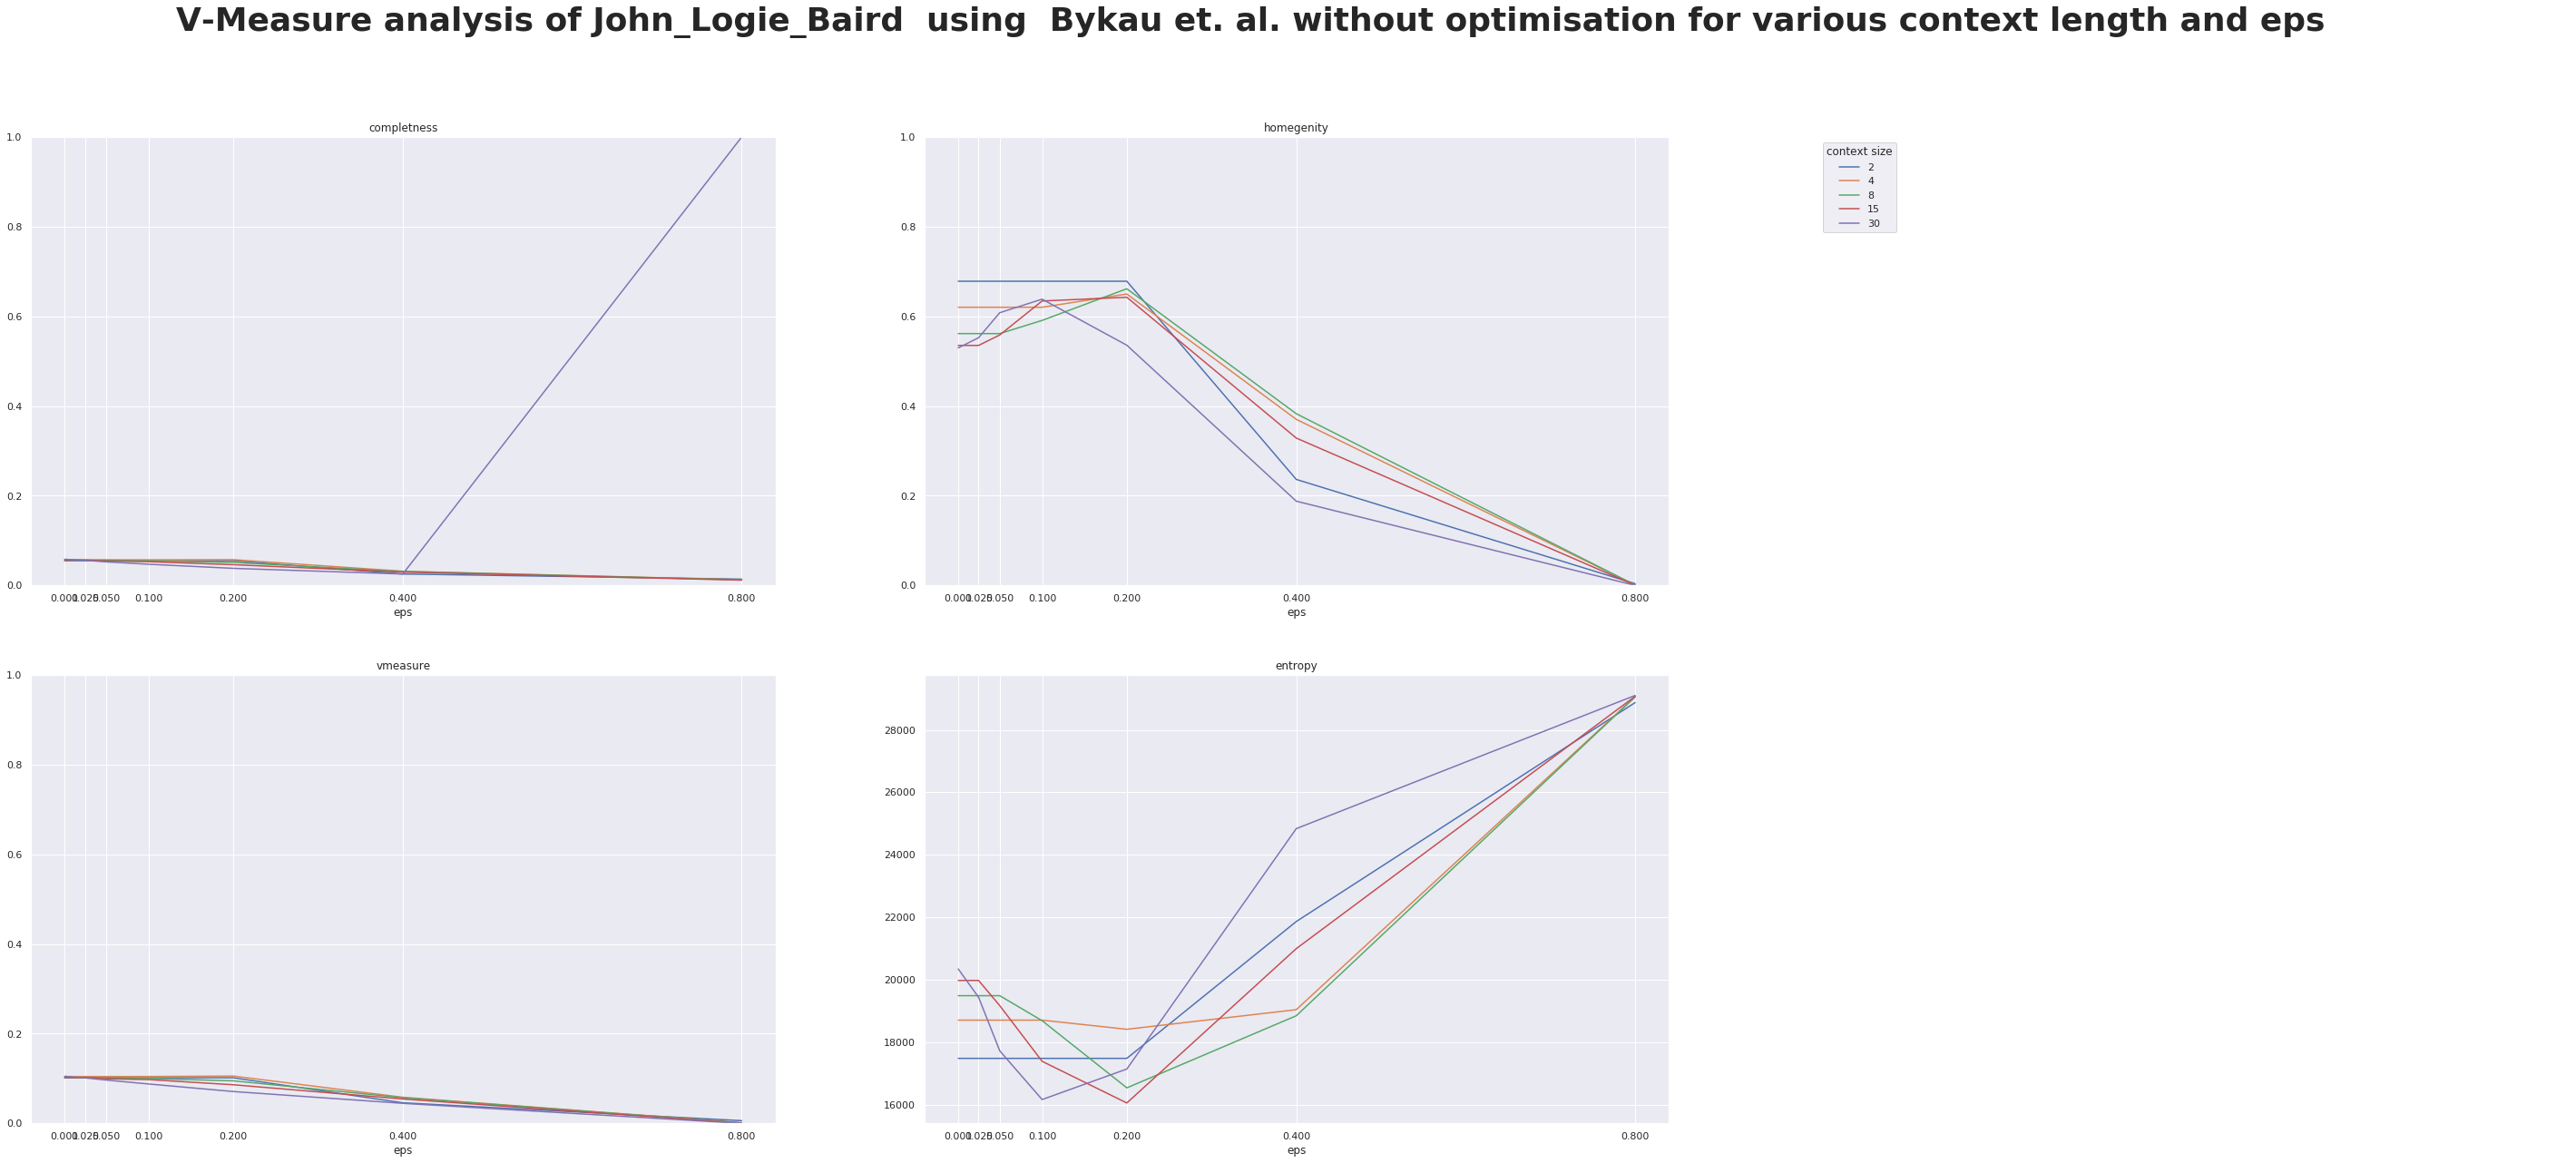

In [42]:
_df = bykau_evaluation_without_optimization.reset_index()

cols = [
    'change_object_completness', 'change_object_homegenity', "Legend",
    "change_object_vmeasure", "token_entropy",
]


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(50,20))
fig.suptitle(f'V-Measure analysis of John_Logie_Baird  using  Bykau et. al. without optimisation for various context length and eps ', 
            fontsize=36, fontweight="bold")
axes[0,0].set_ylim([0,1])
axes[0,1].set_ylim([0,1])
axes[1,0].set_ylim([0,1])

for i, column in enumerate(cols):
    if column =="Legend":
            
            handles, labels = _ax.get_legend_handles_labels()
            #fig.legend(handles, labels, loc='lower right')
            _ax = axes[int(i/3),i%3]
            _ax.legend(handles, labels, loc='upper left')
            _ax.axis('off')

    else:
#         _ax = axes[i]
        _ax = axes[int(i/3),i%3]


#         _ax.xaxis.label.set_visible(False)
#         _ax.legend(False)
        _ax.set_xlabel("eps")

        for name2, subdf2 in _df.groupby(['context']): 
            subdf2.plot(x = 'eps', y=column, ax=_ax, label=str(name2), title=column.split("_")[-1],  xticks=eps_array, legend=False)

handles, labels = _ax.get_legend_handles_labels()
axes[0,2].legend(handles, labels, loc='upper left', title="context size",)
# axes[3].legend(handles, labels, loc='upper left', title="context size",)


axes[0,2].axis('off')
axes[1,2].axis('off')

fig.savefig("visualisation/jlb-bykau-without-opt.png", dpi=600)



